# ORIE 5230 - Final Project: Cointegration
## Henry Lee (HHL38)
## Ruben Alejandro Ruiz Gomez (RR737) 

### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
import statsmodels.api as sm
import empyrical as ep

### Download List of All Stocks Listed in NYSE, NASDAQ, and AMEX
https://old.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=nasdaq&render=download  
https://old.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=amex&render=download  
https://old.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=nyse&render=download

### Download Stock Adjusted Close Prices

In [2]:
def get_tickers():
    nyse = pd.read_csv("Data/nysecompanylist.csv")[["Symbol","Name","Sector","LastSale"]]
    nyse_tickers = list(nyse.dropna()["Symbol"])
    nasdaq = pd.read_csv("Data/nasdaqcompanylist.csv")[["Symbol","Name","Sector","LastSale"]]
    nasdaq_tickers = list(nasdaq.dropna()["Symbol"])
    amex = pd.read_csv("Data/amexcompanylist.csv")[["Symbol","Name","Sector","LastSale"]]
    amex_tickers = list(amex.dropna()["Symbol"])
    return nyse_tickers,nasdaq_tickers,amex_tickers

def get_prices(tickerlist,startdate,enddate):
    prices = yf.download(tickerlist,start=startdate,end=enddate)["Adj Close"]
    first = prices.iloc[0]
    usetickers = list(first[first.notnull()].index)
    prices = prices[usetickers]
    return prices

def download_all_prices(startdate,enddate):
    nyse_tickers,nasdaq_tickers,amex_tickers = get_tickers()
    NYSE = download_prices(nyse_tickers,startdate,enddate)
    NYSE.to_csv("Data/NYSE.csv")
    NASDAQ = download_prices(nasdaq_tickers,startdate,enddate)
    NASDAQ.to_csv("Data/NASDAQ.csv")
    AMEX = download_prices(amex_tickers,startdate,enddate)
    AMEX.to_csv("Data/AMEX.csv")
    nyse_tickers = list(NYSE.columns)
    nasdaq_tickers = list(NASDAQ.columns)
    amex_tickers = list(AMEX.columns)
    nasdaq_tickers = [i for i in nasdaq_tickers if i not in nyse_tickers]
    amex_tickers = [i for i in amex_tickers if i not in (nyse_tickers+nasdaq_tickers)]
    df = NYSE.join(NASDAQ[nasdaq_tickers],how="left").join(AMEX[amex_tickers],how="left")
    df.to_csv("Data/allprices.csv")
    return df[np.sort(df.columns)]

### Download adjusted close price for all tickers in NYSE, NASDAQ, and AMEX exchanges
- Out of the 2095 tickers in NYSE, only 1531 have prices for the full 5 years. 
- Out of the 3335 tickers in NASDAQ, only 1865 have prices for the full 5 years.
- Out of the 207 tickers in AMEX, only 169 have tickers for the full 5 years.

In [3]:
startdate="2015-01-01"
enddate="2020-01-01"
# prices = download_all_prices(startdate,enddate)

### Use Downloaded Prices Instead of Downloading Again; Calculate Returns

In [4]:
prices = pd.read_csv("Data/allprices.csv",index_col=0).dropna(how="all")
prices.index = pd.DatetimeIndex(prices.index)
returns=prices.pct_change().dropna()
returns

,A,AA,AAN,AAP,AAT,AB,ABB,ABBV,ABC,ABEV,...,UUUU,VGZ,VNRX,VOLT,WRN,WTT,WYY,XPL,XTNT,XXII
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.057935,-0.003919,-0.013181,0.011395,-0.034100,-0.033207,-0.018819,-0.008512,-0.018487,...,-0.134740,0.034483,-0.025000,-0.024738,0.000000,0.030651,-0.035971,0.011111,-0.030000,-0.051429
2015-01-06,-0.015578,0.007353,-0.037377,-0.000703,0.007837,-0.023007,-0.013739,-0.004950,0.005463,0.037671,...,-0.003752,0.133333,0.000000,0.010732,0.000000,0.003717,0.111940,0.000000,-0.020618,-0.048193
2015-01-07,0.013272,0.025879,0.030313,0.021489,0.018955,0.010556,-0.002488,0.040417,0.019960,0.016502,...,0.015066,0.000000,0.215385,0.021236,-0.016667,-0.011111,0.000000,-0.010989,0.000000,-0.018987
2015-01-08,0.029975,0.028461,0.016198,0.008765,0.005962,0.024508,0.012968,0.010459,0.002283,0.010612,...,-0.012987,0.029412,-0.008439,0.001890,0.016949,0.011236,0.006711,0.000000,0.024561,0.012903
2015-01-09,-0.007337,0.013208,-0.012036,-0.005089,0.001660,0.004314,-0.010832,-0.027355,0.008786,0.014540,...,0.007519,0.028571,0.021277,-0.004717,-0.050000,0.000000,0.033333,0.033333,-0.013699,-0.031847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.000469,0.004656,-0.001545,0.003751,-0.001562,0.001661,-0.002504,-0.004432,-0.002103,-0.004367,...,0.005348,0.092308,0.012146,0.017391,0.012195,0.000000,-0.025000,-0.035714,0.000000,0.090000
2019-12-26,0.001759,-0.006024,-0.020805,-0.008096,0.004695,0.002653,0.006695,-0.000223,-0.004331,0.032895,...,-0.010638,0.070423,0.010000,0.021368,0.036145,0.000000,-0.025641,0.074074,0.096774,0.027523
2019-12-27,-0.000351,0.006061,-0.010887,-0.005776,0.006898,-0.009262,0.002078,-0.007013,-0.001646,0.000000,...,0.000000,-0.052632,-0.089109,-0.008368,-0.046512,0.007407,0.052632,0.034483,-0.017647,0.017857


## Initial Stock Universe Selection using Training Data 2015-2017
3552 is too many stocks to select from and will require a lot of computational power. We will try to narrow down our stock universe based on stocks that appear in top correlation pairs. This initial test will utilize our training data, which we define to be 2015 to 2017.

### Calculate Correlations and Calculate the Top Pairs Based on Correlation
Although correlation and cointegration is not the same thing. In practice, cointegrated assets are also correlated.

In [5]:
train = returns["2015":"2017"].copy()
corrs = train.corr()
tickers = corrs.columns
temp = []
for i in range(len(tickers)):
    for j in range(i+1,len(tickers)):
        temp.append([tickers[i],tickers[j],corrs.iloc[i,j]])
pairs = pd.DataFrame(temp,columns=["Ticker1","Ticker2","Correlation"]).sort_values("Correlation",ascending=False)
pairs.head(20)

,Ticker1,Ticker2,Correlation
5575418,IAC,MTCH,1.000000
8191,AAN,PRG,1.000000
5459625,GOOG,GOOGL,0.989062
5389241,FWONA,FWONK,0.981544
5732520,LBRDA,LBRDK,0.980883
548680,BBL,BHP,0.978122
873236,CCL,CUK,0.977934
5118466,DISCA,DISCK,0.972923
5783465,LTRPA,TRIP,0.965428
5956710,NWS,NWSA,0.961348


### Drop Multi-Class Shares using Analysis from Top Correlation Pairs
These were correlated with another stock from the same company, thus having correlations of higher than 0.95. Through the trading strategy, these correlations will be recalculated. Correlations above 0.95 will not be considered and assumed to be due to multi-class or majority share ownership.

In [6]:
pairs=pairs[pairs.Correlation < 0.95]
pairs.head(20)

,Ticker1,Ticker2,Correlation
1075378,CMS,XEL,0.913970
542441,BBD,ITUB,0.906945
4788584,CATY,CVBF,0.902593
1072469,CMS,DTE,0.900130
5057777,CVBF,FMBI,0.899642
5057820,CVBF,GBCI,0.899197
2581766,LNC,PRU,0.898987
800873,C,JPM,0.898851
4146292,WEC,XEL,0.896908
5058810,CVBF,TRMK,0.896838


### To reduce computational complexity, only the 500 companies will be selected. These will be selected from the top pairs list. This will significantly reduce correlation and pairs calculation computation time.

In [7]:
N = 500
use_tickers = []
n = 0
i = 0
j = 0
while n < N:
    if not (pairs.iloc[i,j] in use_tickers):
        use_tickers.append(pairs.iloc[i,j])
        n = n+1
    if j == 0:
        j = j+1
    else:
        j = 0
        i = i+1
len(use_tickers)
prices=prices[use_tickers]
returns=returns[use_tickers]

### Trading Strategy Idea
At the beginning of every month, use previous 3 months data to determine top 10 correlated stocks. Do pair trading on the top n of these? With 252 trading days per year, 63 days will be used per period. The backtest period will be from 2018 to 2019.

### Days for Correlation Recalculation
The recalculations will be done on the first trading date after Jan 1, April 1, July 1, and October 1.

In [8]:
startdate = "2018-01-01"
recalc_dates = list(pd.to_datetime(["2018-01-01","2018-04-01","2018-07-01","2018-10-01"]))
recalc_dates = recalc_dates + list(pd.to_datetime([dt.date(d.year+1,d.month,d.day) for d in recalc_dates]))
recalc_dates = [returns[d:].index[0] for d in recalc_dates]
all_recalc_dates = [pd.to_datetime("2017-10-01")] + recalc_dates + [pd.to_datetime("2020-01-01")]
recalc_dates

[Timestamp('2018-01-02 00:00:00'),
 Timestamp('2018-04-02 00:00:00'),
 Timestamp('2018-07-02 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00')]

## Trading Strategy
- For each recalculation date, determine the new pairs to be traded (top 10 correlated pairs with <0.95 correlation)
- Use linear regression fit on previous period for each pair to determine the signal and slope
- Weight each pair trade using the signal strength (absolute value of signal)
- Weight each stock within a pair using Beta (the slope) such that the absolute value of the weights given to each ticker equals the weight assigned to the pair
- Hold the assigned weights for each stock until the next recalculation date

In [9]:
# Determine the topn pairs with highest correlation
def calc_top_pairs(returns,tickers,topn,max_corr=0.95):
    c = returns.corr()
    temp = []
    for i in range(len(tickers)):
        for j in range(i+1,len(tickers)):
            temp.append([tickers[i],tickers[j],c.iloc[i,j]])
    p = pd.DataFrame(temp,columns=["Ticker1","Ticker2","Correlation"]).sort_values("Correlation",ascending=False)
    p = p[p.Correlation<max_corr].head(topn)
    return p

# Get slope and signal from each pair
def cointegrate(pA,pB):
    log_pA=np.log(pA)
    log_pB=np.log(pB)
    X = sm.add_constant(log_pB)
    res = sm.OLS(log_pA, X).fit() 
    constant=res.params[0]
    slope=res.params[1]
    portfolio=constant+slope*log_pB
    signal=log_pA-portfolio
    return slope,signal 

### Example Using the First Recalculation Date 2018-01-02

In [10]:
i= 1
start_date = all_recalc_dates[i-1]
current_date = all_recalc_dates[i]
end_date = all_recalc_dates[i+1]
hist_returns = returns[all_recalc_dates[i-1]:all_recalc_dates[i]].copy()
pairs = calc_top_pairs(hist_returns,use_tickers,10)
signals = []
slopes = []
for j in range(len(pairs)):
    pA = prices[pairs["Ticker1"].iloc[j]][start_date:current_date].dropna()
    pB = prices[pairs["Ticker2"].iloc[j]][start_date:current_date].dropna()
    slope,signal =cointegrate(pA,pB)
    signals.append(signal[-1])
    slopes.append(slope)
pairs["Signal"] = signals
pairs["Beta"] = slopes
pairs["PairWeight"] = pairs.Signal.abs()/pairs.Signal.abs().sum()
pairs["Weight1"] = pairs.PairWeight / (1+pairs.Beta) * -np.sign(pairs.Signal)
pairs["Weight2"] = pairs.PairWeight * pairs.Beta/(1+pairs.Beta) * np.sign(pairs.Signal)
pairs

,Ticker1,Ticker2,Correlation,Signal,Beta,PairWeight,Weight1,Weight2
31222,CHTR,LBRDA,0.948369,0.023915,0.900549,0.123759,-0.065118,0.058642
997,BBD,ITUB,0.940752,-0.007276,1.298399,0.037653,0.016382,-0.021271
31237,CHTR,LBRDK,0.935793,0.030726,0.838907,0.159007,-0.086468,0.072539
11240,PNW,LNT,0.931163,-0.016332,0.991153,0.084518,0.042447,-0.042071
44950,RUSHA,RUSHB,0.931082,-0.012115,1.029455,0.062697,0.030894,-0.031804
105049,AMAT,LRCX,0.923565,0.005293,0.728690,0.027391,-0.015845,0.011546
6943,TRMK,UBSI,0.921120,-0.016036,0.640912,0.082983,0.050571,-0.032412
2486,CVBF,FMBI,0.916022,-0.017256,0.513978,0.089298,0.058982,-0.030315
2076,CATY,WABC,0.912612,0.014997,0.762030,0.077609,-0.044045,0.033564
1999,CATY,TRMK,0.911056,0.049292,0.750465,0.255086,-0.145724,0.109361


### Example of Slope and Signal for the Most Correlated Pair

Last Signal:  0.0239
Slope:  0.9005


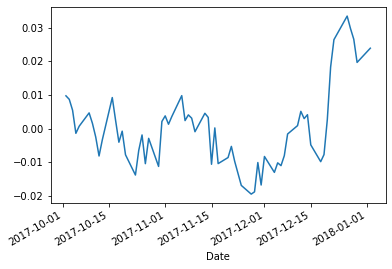

In [11]:
j = 0
pA = prices[pairs["Ticker1"].iloc[j]][start_date:current_date].dropna()
pB = prices[pairs["Ticker2"].iloc[j]][start_date:current_date].dropna()
slope,signal =cointegrate(pA,pB)
signal.plot()
print("Last Signal: ",signal[-1].round(4))
print("Slope: ",slope.round(4))

### Backtest Out of Sample Results for Portfolio for the Following Period Up Until the Next Recalculation Date

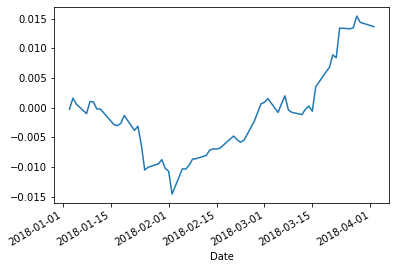

In [12]:
test_returns = returns[current_date:end_date][list(pairs.Ticker1)+list(pairs.Ticker2)].iloc[1:]
weighted_returns = test_returns.multiply(list(pairs.Weight1)+list(pairs.Weight2))
portfolio_returns = weighted_returns.sum(axis=1)
portfolio_returns.cumsum().plot()

### Complete the Entire Backtest over 2018-01-02 to 2019-12-31

In [13]:
# Start Trading, Recalculate Every 3 Months
topn = 10 # trade the top n most correlated pairs

port_rets = []
for i in range(1,len(all_recalc_dates)-1):
    start_date = all_recalc_dates[i-1]
    current_date = all_recalc_dates[i]
    end_date = all_recalc_dates[i+1]
    hist_returns = returns[all_recalc_dates[i-1]:all_recalc_dates[i]].copy()
    pairs = calc_top_pairs(hist_returns,use_tickers,topn)
    signals = []
    slopes = []
    for j in range(len(pairs)):
        pA = prices[pairs["Ticker1"].iloc[j]][start_date:current_date].dropna()
        pB = prices[pairs["Ticker2"].iloc[j]][start_date:current_date].dropna()
        slope,signal =cointegrate(pA,pB)
        signals.append(signal[-1])
        slopes.append(slope)
    pairs["Signal"] = signals
    pairs["Beta"] = slopes
    pairs["PairWeight"] = (pairs.Signal**2)/(pairs.Signal**2).sum()
    pairs["Weight1"] = pairs.PairWeight / (1+pairs.Beta) * -np.sign(pairs.Signal)
    pairs["Weight2"] = pairs.PairWeight * pairs.Beta/(1+pairs.Beta) * np.sign(pairs.Signal)
    test_returns = returns[current_date:end_date][list(pairs.Ticker1)+list(pairs.Ticker2)].iloc[1:]
    weighted_returns = test_returns.multiply(list(pairs.Weight1)+list(pairs.Weight2))
    portfolio_returns = weighted_returns.sum(axis=1)
    port_rets.append(portfolio_returns)

### Analyze Portfolio Performance

Text(0, 0.5, 'Portfolio Cumulative Returns')

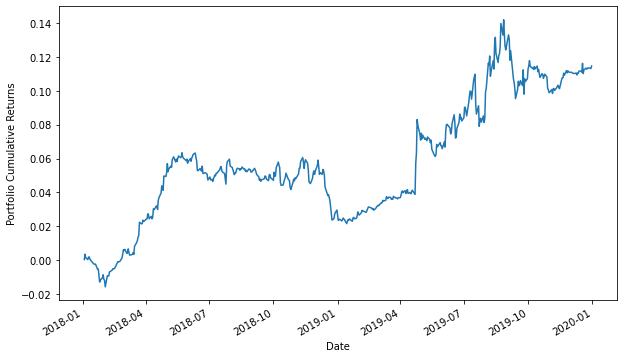

In [14]:
df = pd.DataFrame({"PortfolioReturns":pd.concat(port_rets)})
df["PortfolioCumulativeReturns"] = (1+df.PortfolioReturns).cumprod()-1
df.PortfolioCumulativeReturns.plot(figsize=(10,6))
plt.ylabel("Portfolio Cumulative Returns")

In [15]:
print("Annualized Returns: ",np.round(ep.annual_return(df.PortfolioReturns)*100,2),"%")
print("Annualized Volatility: ",np.round(ep.annual_volatility(df.PortfolioReturns)*100,2),"%")
print("Sharpe Ratio: ",np.round(ep.sharpe_ratio(df.PortfolioReturns),3))
print("Max Drawdown: ",np.round(ep.max_drawdown(df.PortfolioReturns)*100,2),"%")

Annualized Returns:  5.6 %
Annualized Volatility:  5.42 %
Sharpe Ratio:  1.033
Max Drawdown:  -4.07 %


## Get Baseline Strategy Performance (Homework 4)

In [16]:
def get_sp500_ticker_list():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    history = table[1][[("Date","Date"),("Added","Ticker"),("Removed","Ticker")]]
    table = table[0]

    # Some companies have multiple classes of shares, we will keep the Class A shares
    # table[table["CIK"].duplicated(False)] 
    table.drop_duplicates(subset=["CIK"],keep="first",inplace=True)
    list_symbols = list(table["Symbol"].str.replace(".","-"))
    
    return list_symbols

def get_prices(startdate,enddate,list_symbols,read_csv = False):
    if read_csv:
        prices = pd.read_csv("Data/baselineprices.csv",index_col="Date")
        prices.index = pd.DatetimeIndex(prices.index)
        return prices
    prices = yf.download(list_symbols,start=startdate,end=enddate)["Adj Close"]
    prices.to_csv("Data/baselineprices.csv")
    return prices

startdate="2015-01-01"
enddate="2020-01-01"

list_symbols = get_sp500_ticker_list()
prices2 = get_prices(startdate,enddate,list_symbols)
prices2.dropna(how="all",inplace=True)
returns2 = prices2.pct_change()
returns2 = returns2.iloc[1:,:]
pairs2 = calc_top_pairs(returns2[:"2017"],returns2.columns,10)

[*********************100%***********************]  500 of 500 completed

4 Failed downloads:
- VNT: Data doesn't exist for startDate = 1420088400, endDate = 1577854800
- OTIS: Data doesn't exist for startDate = 1420088400, endDate = 1577854800
- CARR: Data doesn't exist for startDate = 1420088400, endDate = 1577854800
- LUMN: No data found for this date range, symbol may be delisted


In [18]:
pairs2

,Ticker1,Ticker2,Correlation
46529,CMS,XEL,0.913970
46183,CMS,DTE,0.900130
100534,LNC,PRU,0.898987
34829,C,JPM,0.898851
124463,WEC,XEL,0.896908
26422,BAC,C,0.896735
67786,ES,XEL,0.892977
116354,PNW,XEL,0.891296
118532,RF,ZION,0.891216
116060,PNC,USB,0.890980


In [19]:
tickerA = pairs2.Ticker1.iloc[0]
tickerB = pairs2.Ticker2.iloc[0]
pA = prices2[tickerA][:"2017"]
pB = prices2[tickerB][:"2017"]
slope2,signal2 = cointegrate(pA,pB)
print("Slope: ",slope2)
print("Signal: ",signal2[-1])

Slope:  0.9755286899988074
Signal:  -0.02143388108185551


### Baseline Strategy
Utilize training data to determine top pair and slope/signal of the top pair. Long/short the pair for the entire backtesting period using the slope and signal to determine the position.

Annualized Returns:  0.27 %
Annualized Volatility:  3.33 %
Sharpe Ratio:  0.098
Max Drawdown:  -4.25 %


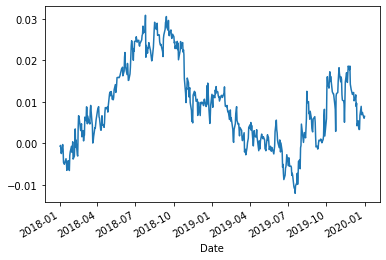

In [20]:
positionA = 1/(1+slope2)*-np.sign(signal2[-1])
positionB = slope2/(1+slope2)*np.sign(signal2[-1])
r2 = returns2[[tickerA,tickerB]]["2018":]
r2["BaselineReturn"] = r2[tickerA]*positionA+r2[tickerB]*positionB
r2["BaselineCumulativeReturn"] = r2.BaselineReturn.cumsum()
r2.BaselineCumulativeReturn.plot()
print("Annualized Returns: ",np.round(ep.annual_return(r2.BaselineReturn)*100,2),"%")
print("Annualized Volatility: ",np.round(ep.annual_volatility(r2.BaselineReturn)*100,2),"%")
print("Sharpe Ratio: ",np.round(ep.sharpe_ratio(r2.BaselineReturn),3))
print("Max Drawdown: ",np.round(ep.max_drawdown(r2.BaselineReturn)*100,2),"%")

## Comparison of Strategies

In [21]:
ratios = pd.DataFrame([["Annualized Returns",ep.annual_return(df.PortfolioReturns),ep.annual_return(r2.BaselineReturn)],
         ["Annualized Volatility",ep.annual_volatility(df.PortfolioReturns),ep.annual_volatility(r2.BaselineReturn)],
         ["Sharpe Ratio",ep.sharpe_ratio(df.PortfolioReturns),ep.sharpe_ratio(r2.BaselineReturn)],
         ["Max Drawdown",ep.max_drawdown(df.PortfolioReturns),ep.max_drawdown(r2.BaselineReturn)]],
         columns=["Index","Trading Strategy","Baseline"]).set_index("Index")
ratios

,Trading Strategy,Baseline
Index,,
Annualized Returns,0.055979,0.002713
Annualized Volatility,0.054172,0.033255
Sharpe Ratio,1.032597,0.098056
Max Drawdown,-0.040730,-0.042457


Text(0, 0.5, 'Cumulative Returns')

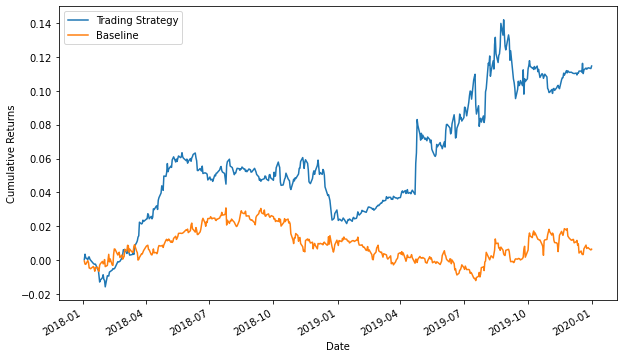

In [22]:
plotter = pd.DataFrame({"Trading Strategy":df.PortfolioCumulativeReturns,"Baseline":r2.BaselineCumulativeReturn}).dropna()
plotter.plot(figsize=(10,6))
plt.ylabel("Cumulative Returns")

## Future Improvements
- Parameter tuning: number of traded pairs, weighting, recalculation window
- Instead of limiting to just 500 of the most correlated stocks, we could instead open to the entire universe but that would be computationally taxing